In [1]:
import numpy as np
import tensorflow as tf
import scipy.io
from keras import backend as K
from keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
import matplotlib.pyplot as plt

In [2]:
# define the filename to save the weights of the model as a .mat
filename = 'models/classify_subsytem'

# define the interval of the domain for the input-output dynamics
lower_limit_x = 0
lower_limit_y = 0

upper_limit_x = 2
upper_limit_y = 2

step_size = 0.01;

# define the approximate size the small offset parameter in the smooth ReLU
gamma = 0.01

# define the approximate size the feedback offset parameter in the feedback motif
beta_1_and_2 = 1

# define the number of hidden species in a single hidden layer
N = 4

# define the number of epochs to use in training the model
number_of_epochs = 1

#define data
x1_train = np.arange(lower_limit_x, upper_limit_x, step_size, dtype="float32")
x2_train = np.arange(lower_limit_y, upper_limit_y, step_size, dtype="float32")

x1v, x2v = np.meshgrid(x1_train, x2_train, indexing='ij')
nx1 = len(x1_train)
nx2 = len(x2_train)
y1_train = ((x1v > 1) != ( x2v > 1 )).astype(np.int32)

x_train = np.append(x1v.reshape(-1,1), x2v.reshape(-1,1),axis=1)
y_train = y1_train.reshape(-1,1)

In [3]:
# define the custom activation function for the training with particular values of the relu_offset
def smooth_max_activation(x):
    return 0.5*(x + K.sqrt(K.square(x)+4*gamma))

get_custom_objects().update({'smooth_max_activation': Activation(smooth_max_activation)})

# define a neural network model that corresponds to the asymptotic neural subsytem 
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,), name=''),
  tf.keras.layers.Dense(N, activation='smooth_max_activation'),
  tf.keras.layers.Dense(1, activation='smooth_max_activation'),
])

# compile model with optimizer and choice of loss function
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# train the neural network model to replicate x_train -> y_train
model.fit(x_train, y_train, epochs=number_of_epochs, validation_split = 0.1, verbose=1)

1125/1125 [==============================] - 2s 950us/step - loss: 0.2259 - mse: 0.2259 - val_loss: 0.2593 - val_mse: 0.2593


In [4]:
# apply ANN to input domain
y_pred = model.predict(x_train)
y_pred_mesh = y_pred.reshape(x1v.shape[0], x1v.shape[0] )

1250/1250 [==============================] - 1s 639us/step


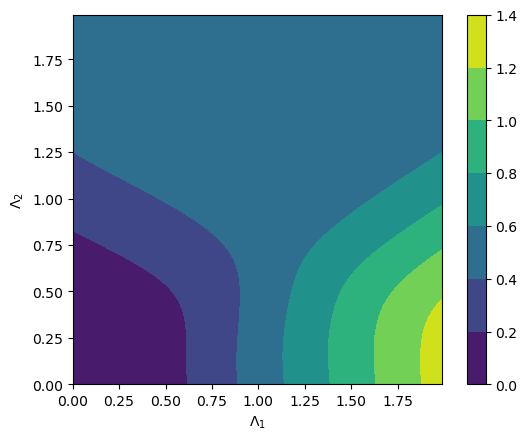

In [5]:
# plot Lambda_1-Lambda_2 map to r-species concentration 
h = plt.contourf(x1_train, x2_train, y_pred_mesh)
plt.axis('scaled')
plt.colorbar()
plt.xlabel('$\Lambda_1$')
plt.ylabel('$\Lambda_2$')
plt.show()

In [6]:
# view the model structure, each 'Param' corresponds to at least one rate of reaction in the chemical system
model.summary()

# save the weights of this neural network for use in ODE simulations in MATLAB
first_layer_weights = model.layers[1].get_weights()[0]
first_layer_biases = model.layers[1].get_weights()[1]
output_layer_weights = model.layers[2].get_weights()[0]
output_layer_biases =  model.layers[2].get_weights()[1]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
  (Flatten)                  (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 4)                 12        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 17 (68.00 Byte)
Trainable params: 17 (68.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
print(first_layer_weights)
print(first_layer_biases)
print(output_layer_weights)
print(output_layer_biases)

[[-0.7323657  -1.0078689  -0.81533855  0.09775895]
 [ 0.44668347  0.25893992 -0.3403167  -1.0879678 ]]
[ 0.0566783  -0.11020989  0.95934534 -0.40988818]
[[ 1.3340232 ]
 [-0.3161746 ]
 [-0.9613578 ]
 [-0.40787706]]
[0.44564617]


In [8]:
scipy.io.savemat(filename+'.mat', {'first_layer_weights':first_layer_weights, 
                                   'first_layer_biases':first_layer_biases, 
                                   'output_layer_weights':output_layer_weights,
                                   'output_layer_biases':output_layer_biases,
                                   'gamma': gamma,
                                  })